# Question 2
导入必要的库

In [2]:
from random_forest_Q2 import *
from scipy.optimize import minimize
from itertools import product, combinations
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import pandas as pd

## 预测人数
### 随机森林模型主流程

交叉验证最佳分数: 0.5369047619047619
最佳参数: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
模型评估指标：
准确率: 0.8000
精确率: 0.8542
召回率: 0.8333
F1分数: 0.8310
AUC值: 0.9259


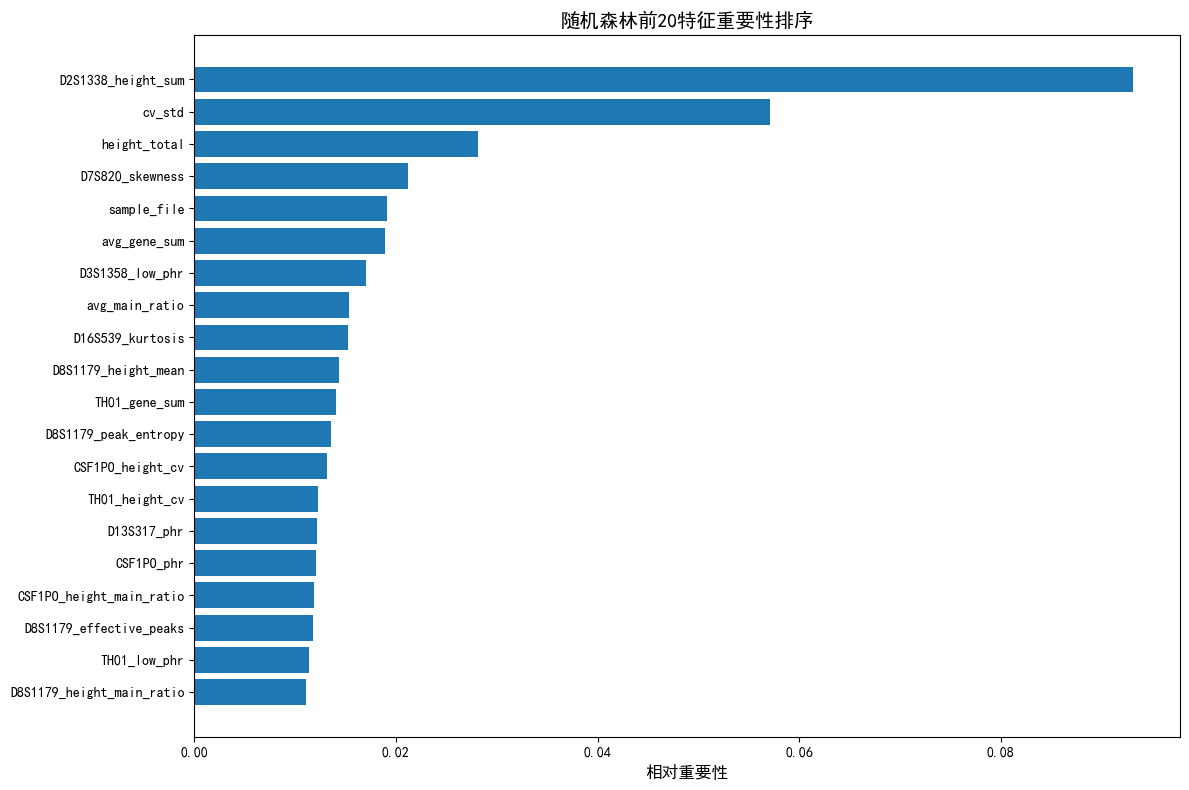

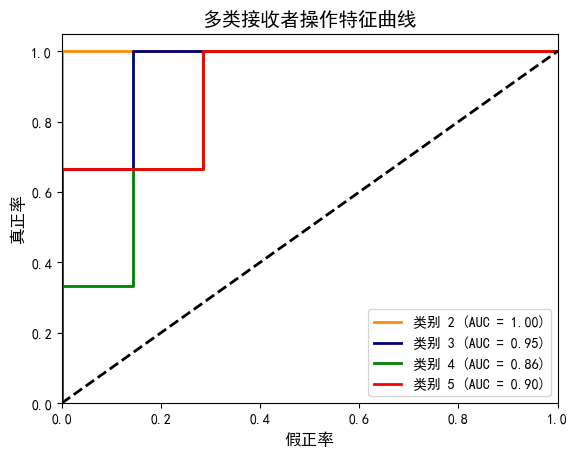

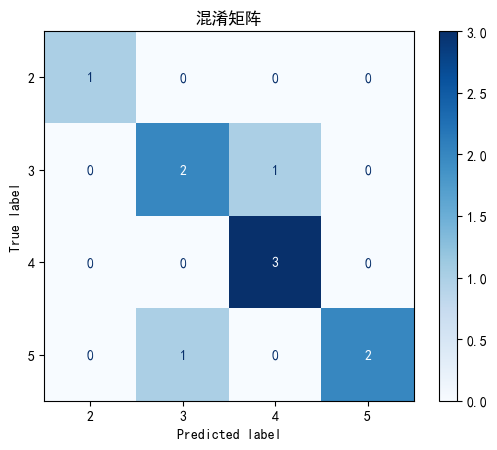

In [3]:
# 1. 加载原始数据
original_data = pd.read_excel('D题附件：法医物证多人身份鉴定问题数据集/附件2：不同混合比例的STR图谱数据_processed.xlsx')

# 2. 加载并预处理模型数据
df = load_and_preprocess(data_path="data/enhanced_processed_Q2_data.xlsx")
X = df.drop(['people', 'gene_from', 'proportion'], axis=1)
y = df['people']

# 划分训练集/测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
test_sample_files = X_test['sample_file']

# 3. 模型训练
rf_model, feature_selector = train_random_forest(
    X_train.drop('sample_file', axis=1),
    y_train
)

# 4. 模型预测
X_test_selected = feature_selector.transform(X_test.drop('sample_file', axis=1))
y_pred = rf_model.predict(X_test_selected)
y_proba = rf_model.predict_proba(X_test_selected)

# 5. 模型评估
print("=" * 40)
print("模型评估指标：")
print(f"准确率: {accuracy_score(y_test, y_pred):.4f}")
print(f"精确率: {precision_score(y_test, y_pred, average='macro'):.4f}")
print(f"召回率: {recall_score(y_test, y_pred, average='macro'):.4f}")
print(f"F1分数: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"AUC值: {roc_auc_score(y_test, y_proba, multi_class='ovo'):.4f}")

# 6. 可视化输出
# 特征重要性图
plot_feature_importance(rf_model, X.columns.tolist(), "images/Q2/feature_importance.png")

# ROC曲线
plot_roc_curve(y_test, y_proba, "images/Q2/roc_curve.png")

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("混淆矩阵")
plt.savefig("images/Q2/confusion_matrix.png", dpi=300)
plt.show()
plt.close()

### 提取测试集数据结果

In [4]:
#合并到原始数据
predictions = pd.DataFrame({
    'Sample File': test_sample_files,
    'predicted_people': y_pred
})
data_test = original_data[original_data['Sample File'].isin(test_sample_files)]
data_test = data_test.merge(predictions, on='Sample File', how='left')

# 将predicted_people列移动到第5列位置
cols = data_test.columns.tolist()
cols.remove('predicted_people')
cols.insert(4, 'predicted_people')  # 插入到第5列位置(索引4)
data_test = data_test[cols]

# 验证每个样本的预测值唯一性
assert data_test.groupby('Sample File')['predicted_people'].nunique().max() == 1

# 5. 输出结果
# data_test.to_excel('data/Q2_temp.xlsx', index=False)

## 预测比例
### 生成贡献矩阵A_i，归一化样本矩阵C

In [28]:
# 基因座数据配置
GENE_LOCI = {
    'D8S1179': [10, 11, 12, 13, 14, 15, 16],
    'D21S11': [24.3, 27, 28, 29, 30, 31, 31.2, 32, 32.2, 33, 33.2, 35, 36],
    'D7S820': [7, 8, 9, 10, 11, 12, 13],
    'CSF1PO': [7, 8, 9, 10, 11, 12, 13],
    'D3S1358': [14, 15, 16, 17, 18],
    'TH01': [5, 6, 7, 8, 9, 9.3],
    'D13S317': [8, 9, 10, 11, 12, 13, 14],
    'D16S539': [8, 9, 10, 11, 12, 13, 14],
    'D2S1338': [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
    'D19S433': [10, 10.2, 11, 12, 12.2, 13, 13.2, 14, 14.2, 15, 15.2, 16, 16.2],
    'vWA': [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'TPOX': [6, 7, 8, 9, 10, 11, 12],
    'D18S51': [10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23],
    'AMEL': ['X', 'Y'],
    'D5S818': [7, 8, 9, 10, 11, 12, 13, 14],
    'FGA': [19, 20, 21, 21.2, 22, 22.2, 23, 24, 25, 26, 27, 28]
}

In [42]:
def generate_C_matrix(sample_name, data_test, GENE_LOCI):
    """
    返回归一化峰高比例矩阵和每个基因座的总峰高

    返回:
    list: 包含16个列表的列表，每个子列表对应一个基因座的峰高比例
    list: 每个基因座的总峰高
    """
    from collections import defaultdict

    # 初始化结果容器
    matrix_data = []
    locus_total_heights = []

    # 获取基因座顺序列表
    loci_order = list(GENE_LOCI.keys())

    # 处理每个基因座
    for locus_name in loci_order:
        alleles = GENE_LOCI[locus_name]
        # 转换标准等位基因格式
        if locus_name == 'AMEL':
            std_alleles = [str(a).upper() for a in alleles]
        else:
            std_alleles = [f"{float(a):g}" for a in alleles]

        # 获取当前基因座数据
        sample_mask = (
            (data_test['Sample File'] == sample_name) &
            (data_test['Marker'].str.upper() == locus_name.upper())
        )
        locus_data = data_test[sample_mask].copy()

        locus_vector = [0.0] * len(std_alleles)
        total_height = 0.0

        if not locus_data.empty:
            allele_counts = defaultdict(float)

            # 遍历所有Allele列
            for col in [c for c in locus_data.columns if c.startswith('Allele')]:
                col_num = col.split()[-1]
                height_col = f'Height {col_num}'

                # 提取等位基因和峰高
                allele = str(locus_data[col].iloc[0]).strip()
                height = locus_data[height_col].iloc[0]

                # 过滤无效数据
                if pd.isna(allele) or pd.isna(height) or 'OL' in allele:
                    continue

                # 格式处理
                try:
                    processed_allele = (
                        allele.upper() if locus_name == 'AMEL'
                        else f"{float(allele):g}"
                    )
                except ValueError:
                    continue

                # 累加峰高值
                allele_counts[processed_allele] += float(height)
                total_height += float(height)

            # 应用动态阈值筛选
            if total_height > 0:
                max_height = max(allele_counts.values(), default=0)
                threshold = max(0.1 * max_height, 0.01 * total_height)

                # 计算有效总峰高（仅限标准等位基因）
                valid_total = sum(allele_counts.get(a, 0) for a in std_alleles)

                if valid_total > 0:
                    # 填充当前基因座的比例向量
                    for i, allele in enumerate(std_alleles):
                        locus_vector[i] = allele_counts.get(allele, 0.0) / valid_total

        matrix_data.append(locus_vector)
        locus_total_heights.append(total_height)

    return matrix_data, locus_total_heights

In [45]:
def generate_valid_allele_combinations_for_locus(C_vector, alleles):
    """
    根据C_vector的非零位置生成该基因座的合法等位基因组合

    参数:
    C_vector: 当前基因座的峰高向量
    alleles: 当前基因座的等位基因列表

    返回:
    该基因座所有合法组合的列表
    """
    n = len(alleles)
    valid_combinations = []

    # 找出C_vector中非零位置的索引
    non_zero_indices = [i for i, height in enumerate(C_vector) if height > 0]

    # 如果没有非零位置，返回空列表
    if not non_zero_indices:
        return []

    # 生成纯合子组合（只考虑非零位置）
    for i in non_zero_indices:
        vec = [0] * n
        vec[i] = 2
        valid_combinations.append(vec)

    # 生成杂合子组合（只考虑非零位置）
    for i in range(len(non_zero_indices)):
        for j in range(i+1, len(non_zero_indices)):
            idx_i = non_zero_indices[i]
            idx_j = non_zero_indices[j]
            vec = [0] * n
            vec[idx_i] = 1
            vec[idx_j] = 1
            valid_combinations.append(vec)

    return valid_combinations

### 范数最优化求解

In [48]:
def estimate_contributors_by_locus(k, C_matrix, locus_total_heights, GENE_LOCI):
    """
    按基因座优化并加权平均的贡献者比例估计（使用首个基因座作为全局参考）
    """
    from itertools import product
    from scipy.optimize import minimize
    import numpy as np

    loci_order = list(GENE_LOCI.keys())
    n_loci = len(loci_order)

    # 存储每个基因座的结果
    locus_results = []
    best_combinations = []
    reference_p = None  # 全局参考比例向量

    # 1. 计算权重
    weights = []
    for i, locus_name in enumerate(loci_order):
        C_vector = np.array(C_matrix[i])
        total_allele_height = np.sum(C_vector)
        weight_i = np.sqrt(total_allele_height) if total_allele_height > 0 else 0
        weights.append(weight_i)

    # 归一化权重
    total_omega = sum(weights)
    normalized_weights = [w / total_omega if total_omega > 0 else 1/n_loci for w in weights]

    # 2. 初始化全局参考（第一个基因座）
    print(f"开始按基因座优化，贡献者人数k={k}")
    print(f"将使用第一个基因座作为全局参考基准")

    for i, locus_name in enumerate(loci_order):
        C_vector = np.array(C_matrix[i])
        alleles = GENE_LOCI[locus_name]

        # 动态生成合法组合（基于C_vector的非零位置）
        valid_combs = generate_valid_allele_combinations_for_locus(C_vector, alleles)

        print(f"\n处理基因座 '{locus_name}'")

        min_residual = float('inf')
        best_p = None
        best_combo = None

        # 检查无效数据情况
        if not valid_combs or locus_total_heights[i] <= 0:
            uniform_p = np.ones(k) / k
            locus_results.append(uniform_p)
            best_combinations.append(None)
            print(f"  无有效数据，使用均匀分布: {uniform_p.round(3)}")
            continue

        # 计算组合数量并输出
        total_combs = len(valid_combs) ** k
        print(f"  考虑{total_combs}种组合...", end='')

        # 穷举组合
        comb_product = list(product(valid_combs, repeat=k))

        for comb in comb_product:
            A_matrix = np.array(comb).T

            def objective(p):
                return np.linalg.norm(A_matrix @ p - C_vector)

            constraints = (
                {'type': 'eq', 'fun': lambda p: np.sum(p) - 1},
                {'type': 'ineq', 'fun': lambda p: p}
            )

            p0 = np.ones(k) / k
            res = minimize(objective, p0, method='SLSQP', constraints=constraints)

            if res.success and res.fun < min_residual:
                min_residual = res.fun
                best_p = res.x
                best_combo = comb

        # 归一化比例
        best_p = np.clip(best_p, 0, None)
        best_p_sum = np.sum(best_p)
        if best_p_sum > 0:
            best_p /= best_p_sum

        # 如果是第一个基因座，设为全局参考
        if i == 0:
            reference_p = best_p.copy()
            print(f"完成! 最小残差={min_residual:.4f}")
            print(f"  设为全局参考比例: {np.round(best_p, 4)}")
        else:
            # 与参考比例调整顺序
            best_p, best_combo = match_to_reference(reference_p, best_p, best_combo)
            print(f"完成! 最小残差={min_residual:.4f}")
            print(f"  调整后比例: {np.round(best_p, 4)}")

        # 输出基因型组合
        print(f"  贡献者基因型组合:")
        for p_idx in range(k):
            combo_vec = best_combo[p_idx]
            allele_strs = []
            for idx, count in enumerate(combo_vec):
                if count > 0:
                    allele_val = alleles[idx]
                    if isinstance(allele_val, float) and allele_val.is_integer():
                        allele_strs.append(f"{int(allele_val)}×{int(count)}")
                    else:
                        allele_strs.append(f"{allele_val}×{int(count)}")
            print(f"    贡献者{p_idx+1}: {' + '.join(allele_strs)}")

        # 保存结果
        locus_results.append(best_p)
        best_combinations.append(best_combo)

    # 3. 加权平均
    final_p = np.zeros(k)
    for j in range(k):
        for i in range(n_loci):
            final_p[j] += normalized_weights[i] * locus_results[i][j]

    final_p_sum = np.sum(final_p)
    if final_p_sum > 0:
        final_p /= final_p_sum

    # 输出最终结果
    print("\n所有基因座处理完成，开始加权平均")
    print(f"最终混合比例: {np.round(final_p, 4)}")
    print(f"比例总和: {np.sum(final_p):.4f}")

    return final_p, locus_results, normalized_weights


def match_to_reference(reference_p, best_p, best_combo):
    """
    将当前基因座的比例向量与参考比例向量匹配

    参数:
    reference_p: 参考比例向量
    best_p: 当前基因座优化后的比例向量
    best_combo: 当前基因座的基因型组合

    返回:
    调整后的比例向量和基因型组合
    """
    k = len(reference_p)

    # 如果k=1无需调整
    if k == 1:
        return best_p, best_combo

    # 计算与参考比例的相关性（原始顺序）
    corr_original = np.corrcoef(reference_p, best_p)[0, 1]

    # 尝试交换顺序
    swapped_p = best_p[::-1].copy()
    swapped_combo = best_combo[::-1]
    corr_swapped = np.corrcoef(reference_p, swapped_p)[0, 1]

    # 选择相关性更高的顺序
    if corr_swapped > corr_original:
        # print(f"  调整顺序以匹配参考（原始相关性={corr_original:.3f}, 调整后={corr_swapped:.3f})")
        return swapped_p, swapped_combo

    return best_p, best_combo

### 模型评估

### 主流程

In [51]:
# 1. 选择样本
sample_name='A10_RD14-0003-48_49_50_29-1;4;4;4-M2a-0.5IP-Q0.4_001.5sec.fsa'

# 2. 生成C矩阵和总峰高
C_matrix, locus_total_heights = generate_C_matrix(sample_name, data_test, GENE_LOCI)

# 3. 获取贡献者人数
k = data_test[data_test['Sample File'] == sample_name]['predicted_people'].iloc[0]

# 4. 执行优化（不再传递valid_comb_dict）
final_p, locus_results, weights = estimate_contributors_by_locus(
    k, C_matrix, locus_total_heights, GENE_LOCI
)

# 5. 输出结果
print(f"\n最终估计比例: {np.round(final_p, 4)}")
print(f"比例总和: {np.sum(final_p):.4f}")
print(f"权重分布: {np.round(weights, 4)}")

开始按基因座优化，贡献者人数k=4
将使用第一个基因座作为全局参考基准

处理基因座 'D8S1179'
  考虑50625种组合...完成! 最小残差=0.4472
  设为全局参考比例: [0.4892 0.0276 0.1497 0.3335]
  贡献者基因型组合:
    贡献者1: 10×1 + 15×1
    贡献者2: 12×2
    贡献者3: 14×2
    贡献者4: 12×1 + 13×1

处理基因座 'D21S11'
  考虑614656种组合...

KeyboardInterrupt: 